In [1]:
import gc

import numpy as np
import torch
from Data.celeba import *
from Model.model import *
# from MomentAccountant.get_priv import *
from Bound.evaluate import *
from Utils.utils import *
from config import parse_args
import os
import json
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
sensitivity = 63.875
epsilon = 0.1
class ClassifierTriplet(nn.Module):
    def __init__(self, embed, n_inputs, n_outputs):
        super(ClassifierTriplet, self).__init__()
        self.kernel_size = embed
        self.fc1 = nn.Linear(n_inputs, self.kernel_size)
        self.fc2 = nn.Linear(self.kernel_size, self.kernel_size)
        self.fc3 = nn.Linear(self.kernel_size, n_outputs)

    def forward(self, x):
        fc1 = self.fc1(x)
        fc1 = F.relu(fc1)
        fc2 = self.fc2(fc1)
        fc2 = F.relu(fc2)
        fc3 = self.fc3(fc1)
        prob = torch.softmax(fc3, dim=1)
        return fc2, fc3, prob



class CelebATriplet(Dataset):
    def __init__(self, target=[0], transform=None, dataroot='../../Datasets/CelebA/embeddings/', mode='valid', imgroot=None, include_tar=True,
                 shuffle=True, multiplier = 100, num_test_point=20):
        self.target = target
        self.target_multiplier = multiplier
        self.num_file_org = len(os.listdir(dataroot))
        self.non_target = list(range(self.num_file_org))
        for i in self.target:
            self.non_target.remove(i)
        self.transform = transform
        self.include = include_tar
        if shuffle:
            random.shuffle(self.non_target)
        self.num_file = len(self.non_target)

        if mode == 'train':
            self.train_data = np.arange(int(0.6 * self.num_file))
            self.length = len(self.train_data)
        elif mode == 'valid':
            self.valid_data = np.arange(int(0.6 * self.num_file), int(0.8 * self.num_file))
            self.length = len(self.valid_data)
        else:
            test_point = np.random.choice(a=np.arange(int(0.6 * self.num_file), int(0.8 * self.num_file)),
                                          size=num_test_point, replace=False)
            self.test_data = test_point
            self.length = len(self.test_data)

        self.dataroot = dataroot
        self.imgroot = imgroot
        self.data_name = sorted(os.listdir(dataroot))
        self.mode = mode
        self.noise_scale = sensitivity / epsilon
        self.sample_rate = 0.05
        self.incl = include_tar
        

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.mode == 'train':
            if idx / self.target_multiplier < len(self.target):
                filename1 = self.data_name[self.target[int(idx / self.target_multiplier)]]
                id2 = np.random.choice(a=np.arange(0, int(0.6*self.num_file)), size=1, replace=False)[0]
                filename2 = self.data_name[self.non_target[self.train_data[id2]]]
                class_id = torch.tensor(int(idx / self.target_multiplier))
                img_tensor1 = torch.load(self.dataroot + filename1)
                img_tensor2 = torch.load(self.dataroot + filename2)
                temp_x = img_tensor1.numpy()
                noise = np.random.laplace(0, self.noise_scale, temp_x.shape)
                temp_x = temp_x + noise
                img_tensor3 = torch.from_numpy(temp_x.astype(np.float32))
                sample = np.random.binomial(1, self.sample_rate, 1)[0]
                if sample:
                    return img_tensor1, img_tensor2, img_tensor3, class_id, filename1
                else:
                    temp_x = img_tensor1.numpy()
                    noise = np.random.laplace(0, self.noise_scale, temp_x.shape)
                    temp_x = temp_x + noise
                    img_tensor1 = torch.from_numpy(temp_x.astype(np.float32))
                    return img_tensor1, img_tensor2, img_tensor3, class_id, filename1
            else:
                idx -= len(self.target) * self.target_multiplier
                filename1 = self.data_name[self.non_target[self.train_data[idx]]]
                id2 = np.random.choice(a=np.arange(0, int(0.6 * self.num_file)), size=1, replace=False)[0]
                filename2 = self.data_name[self.non_target[self.train_data[id2]]]
                filename3 = self.data_name[self.target[0]]
                class_id = torch.tensor(len(self.target))
                img_tensor1 = torch.load(self.dataroot + filename1)
                img_tensor2 = torch.load(self.dataroot + filename2)
                img_tensor3 = torch.load(self.dataroot + filename3)
                sample = np.random.binomial(1, 0.5, 1)[0]
                if sample:
                    return img_tensor1, img_tensor2, img_tensor3, class_id, filename1
                else:
                    temp_x = img_tensor3.numpy()
                    noise = np.random.laplace(0, self.noise_scale, temp_x.shape)
                    temp_x = temp_x + noise
                    img_tensor3 = torch.from_numpy(temp_x.astype(np.float32))
                    return img_tensor1, img_tensor2, img_tensor3, class_id, filename1
        elif self.mode == 'valid':
            if idx / self.target_multiplier < len(self.target):
                filename = self.data_name[self.target[int(idx / self.target_multiplier)]]
                # img_loc = os.path.join(self.dataroot, self.data_name[self.target[idx]])
                class_id = torch.tensor(int(idx / self.target_multiplier))
            else:
                idx -= len(self.target) * self.target_multiplier
                filename = self.data_name[self.non_target[self.valid_data[idx]]]
                # img_loc = os.path.join(self.dataroot, self.data_name[self.valid_data[idx]])
                class_id = torch.tensor(len(self.target))
        else:
            if idx / self.target_multiplier < len(self.target):
                filename = self.data_name[self.target[int(idx / self.target_multiplier)]]
                # img_loc = os.path.join(self.dataroot, self.data_name[self.target[idx]])
                class_id = torch.tensor(int(idx / self.target_multiplier))
            else:
                idx -= len(self.target) * self.target_multiplier
                filename = self.data_name[self.non_target[self.test_data[idx]]]
                # img_loc = os.path.join(self.dataroot, self.data_name[self.valid_data[idx]])
                class_id = torch.tensor(len(self.target))
        img_tensor = torch.load(self.dataroot + filename)
        return img_tensor, class_id, filename

In [3]:
valid_loader = torch.utils.data.DataLoader(
    CelebATriplet(multiplier = 10000),
    shuffle=False,
    num_workers=0, batch_size=20000)

In [4]:
x_valid, y_valid, imgs_valid = next(iter(valid_loader))

In [5]:
y_valid = 1 - y_valid
epsilon = [1.0, 5.0, 10.0]
temp_x = x_valid.numpy()
temp_y = y_valid.numpy()
sizes = np.ones(temp_y.shape)
for i, eps in enumerate(epsilon):
    noise_scale = sensitivity / eps
    if i+1 < len(epsilon):
        noise = np.random.laplace(0, noise_scale, temp_x[i*2000:(i+1)*2000].shape)
        temp_x[i*2000+1:(i+1)*2000+1] = temp_x[i*2000+1:(i+1)*2000+1] + noise
        temp_y[i*2000+1:(i+1)*2000+1] = temp_y[i*2000+1:(i+1)*2000+1] + i
        sizes[i*2000+1:(i+1)*2000+1] = sizes[i*2000+1:(i+1)*2000+1] + i
    else:
        noise = np.random.laplace(0, noise_scale, temp_x[i*2000+1:(i+1)*2000].shape)
        temp_x[i*2000+1:(i+1)*2000] = temp_x[i*2000+1:(i+1)*2000] + noise
        temp_y[i*2000+1:(i+1)*2000] = temp_y[i*2000+1:(i+1)*2000] + i
        sizes[i*2000+1:(i+1)*2000] = sizes[i*2000+1:(i+1)*2000] + i
temp_y[0] = len(epsilon)+1
sizes[0] = len(epsilon)+1

In [6]:
lab_dict = {}
for i in np.unique(temp_y):
    if i == 0:
        lab_dict[i] = 'not target'
    elif i > len(epsilon):
        lab_dict[i] = 'target'
    else:
        lab_dict[i] = 'eps {}'.format(epsilon[i-1])

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [8]:
# tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(temp_x)

In [9]:
pca_results.shape

(20000, 2)

In [10]:
df = pd.DataFrame({
    'x1': pca_results[:,0],
    'x2': pca_results[:,1],
    'label': temp_y,
    'size':sizes
})

In [11]:
df['label'] = df['label'].map(lab_dict)

In [12]:
df.head()

,x1,x2,label,size
0,-0.126708,-0.621812,target,4.0
1,211.609955,-120.927231,eps 1.0,1.0
2,-75.440506,-138.172867,eps 1.0,1.0
3,-24.299736,34.864498,eps 1.0,1.0
4,149.850357,9.875841,eps 1.0,1.0


In [13]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
font = {'size' : 16}

matplotlib.rc('font', **font)

Text(0.5, 1.0, 'Original space of embeddings (PCA)')

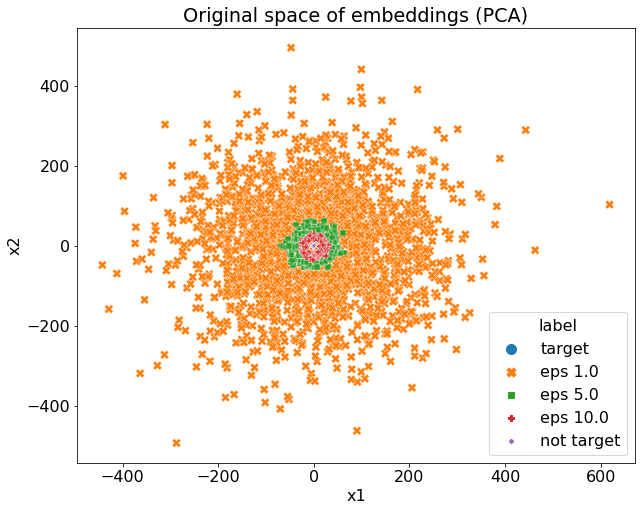

In [14]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=df, x="x1", y="x2", hue="label", size="label",
    sizes=(20, 100), legend="full", style='label'
)
plt.title("Original space of embeddings (PCA)")

In [15]:
model = torch.load('results/debugging_eps_10.0_reg_1.0.pt')
# state_dict
# model.load_state_dict(state_dict['net'])

In [16]:
x_valid = x_valid.to('cpu')
model.to('cpu')
model.eval()
fc2, fc3, prob = model(x_valid)

In [17]:
temp_x = fc2.detach().numpy()
pca_result = pca.fit_transform(temp_x)
df = pd.DataFrame({
    'x1': pca_result[:,0],
    'x2': pca_result[:,1],
    'label': temp_y
})
df['label'] = df['label'].map(lab_dict)

Text(0.5, 1.0, 'Representation of attacking model before classifying (PCA)')

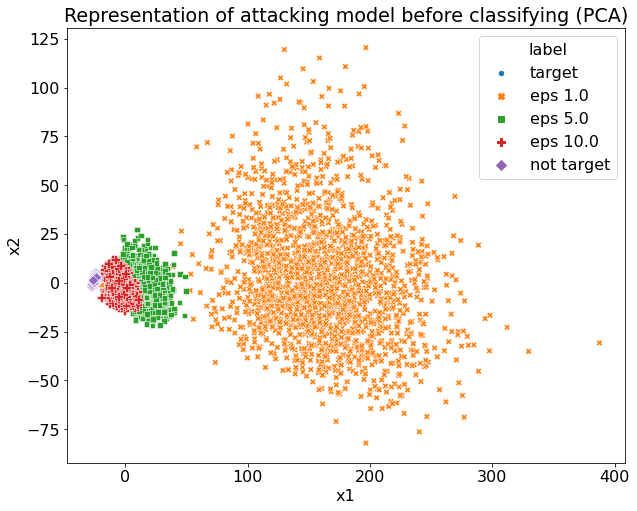

In [18]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=df, x="x1", y="x2", hue="label", size="label",
    sizes=(100, 20), legend="full", style='label'
)
plt.title("Representation of attacking model before classifying (PCA)")